# Exploratory Data Analysis


EDA revealed some interesting trends in the data. We explore some of these trends below. 

**Imports**

In [6]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from datetime import datetime

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## <font color='maroon'>EDA</font>

In [2]:
# this is the file we generated at the end of data cleaning
loan_df = pd.read_pickle('./data/Pickle/clean_df_for_eda.pkl')
loan_df.shape

(1087436, 93)

### Loan Amounts for Fully-Paid vs. Charged Off Loans

The plot below reveals that, on average, loans that end up being fully-paid are smaller (lower loan amount) than those that get charged off.

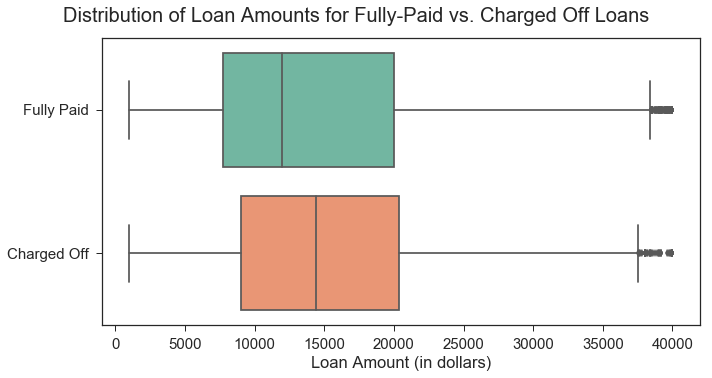

In [3]:
# Just for visualization purposes, we cast some of the binary variables back to more descriptive strings
loan_df['Loan Outcome'] = loan_df['fully_paid'].map({1:'Fully Paid', 0: 'Charged Off'})

# plotting loan_amnt by Loan Outcome
plt.subplots(figsize=(10,5))
plt.suptitle("Distribution of Loan Amounts for Fully-Paid vs. Charged Off Loans", x=.5, y=1.04).set_size(20)
sns.boxplot(x="loan_amnt", y="Loan Outcome", data=loan_df, palette='Set2'
           ).set(xlabel='Loan Amount (in dollars)', ylabel='');
plt.tight_layout()

### Loan Outcome by Grade and Subgrade

Since we will be using the Lending Club's assigned loan grades and subgrades in our model, we should assess whether these grades correspond to the borrower's actual, observed delinquencies on the LC loan. Initial visualization below indicates that the LC loan grades and subgrades do correspond to the portion of loans fully paid; the portion of loans that get fully paid is higher for loans with less-risky loan grades. 

Loan subgrade will likely be one of our model's most important predictors, but we aim to refine our investment strategy by including additional features.

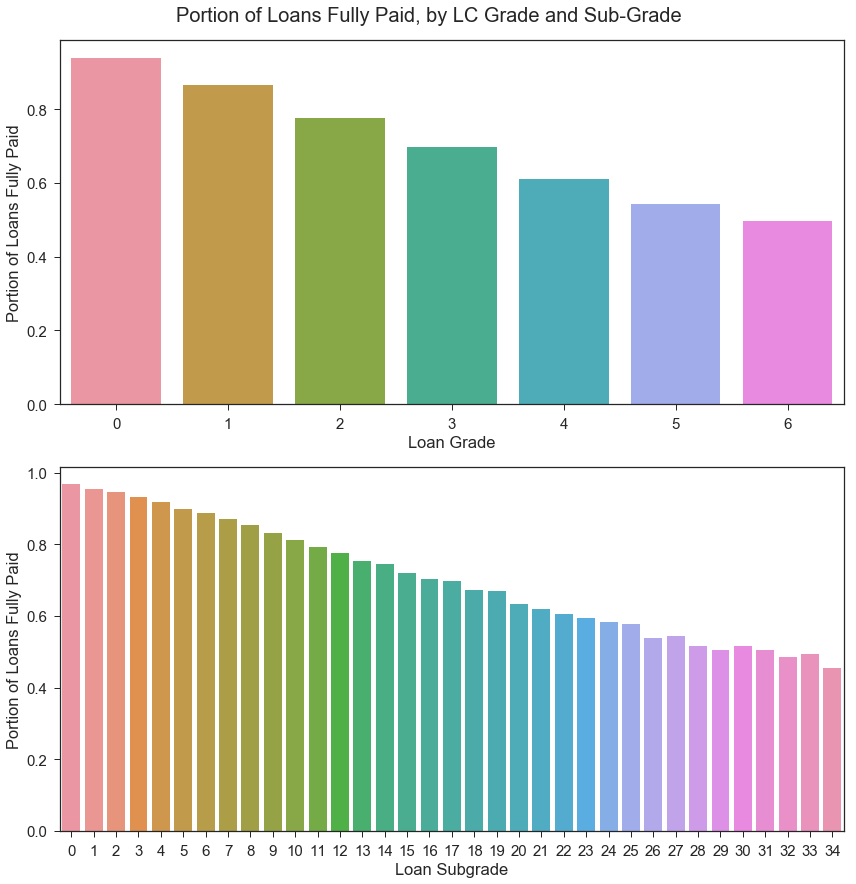

In [4]:
cols = ['grade', 'sub_grade']
labels = ['Loan Grade', 'Loan Subgrade']

fig, axes = plt.subplots(2,1,figsize=(12,12))
for i, ax in enumerate(axes):
    plt_data = loan_df.groupby(cols[i]).agg({'fully_paid': np.mean})
    #ax.set_title("Percentage of Loans that are Fully Paid by {}".format(labels[i]))
    sns.barplot(x=plt_data.index, y=plt_data['fully_paid'], ax=ax
             ).set(xlabel=labels[i],
                   ylabel='Portion of Loans Fully Paid')

fig.suptitle("Portion of Loans Fully Paid, by LC Grade and Sub-Grade", x=.5, y=1.02).set_size(20)
fig.tight_layout()

### Loan Amount by Grade and Subgrade

Below, we observe that lower (less risky) grades/subgrades are associated with lower average loan amounts.

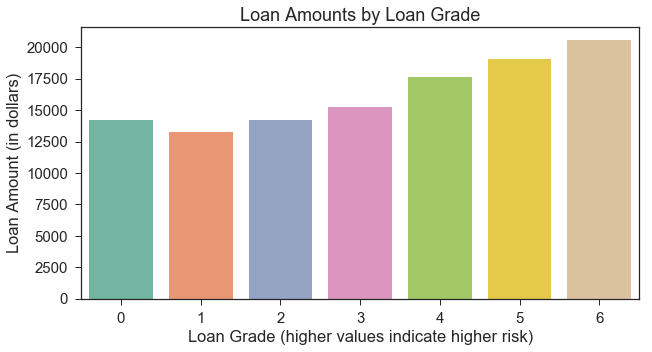

In [5]:
#Loan amount by grade
group = loan_df.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
xticklabels = avg_loan.index.tolist()

plt.subplots(figsize=(10,5))
plt.title("Loan Amounts by Loan Grade")
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2'
           ).set(xlabel='Loan Grade (higher values indicate higher risk)', ylabel='Loan Amount (in dollars)',
                 xticklabels=xticklabels);


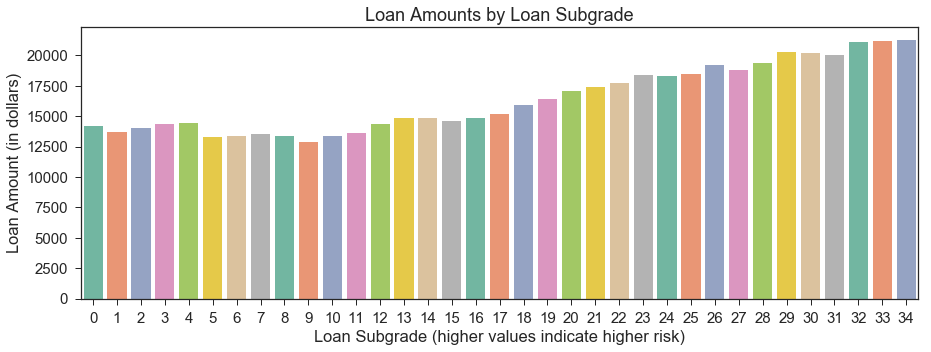

In [6]:
#Loan amount by sub_grade
group = loan_df.groupby("sub_grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,5))
plt.title("Loan Amounts by Loan Subgrade")
sns.barplot(x='sub_grade', y='loan_amnt', data=avg_loan, palette='Set2'
           ).set(xlabel='Loan Subgrade (higher values indicate higher risk)', ylabel='Loan Amount (in dollars)');

### Number of Loans in Dataset by State

Below, we see that a large number of loans are issued to borrowers in California, Texas, New York, and Florida relative to the number of loans issued in other states. We may compare loan performance by state, but we should ensure that our investment strategies do not discriminate based on a borrower's state.

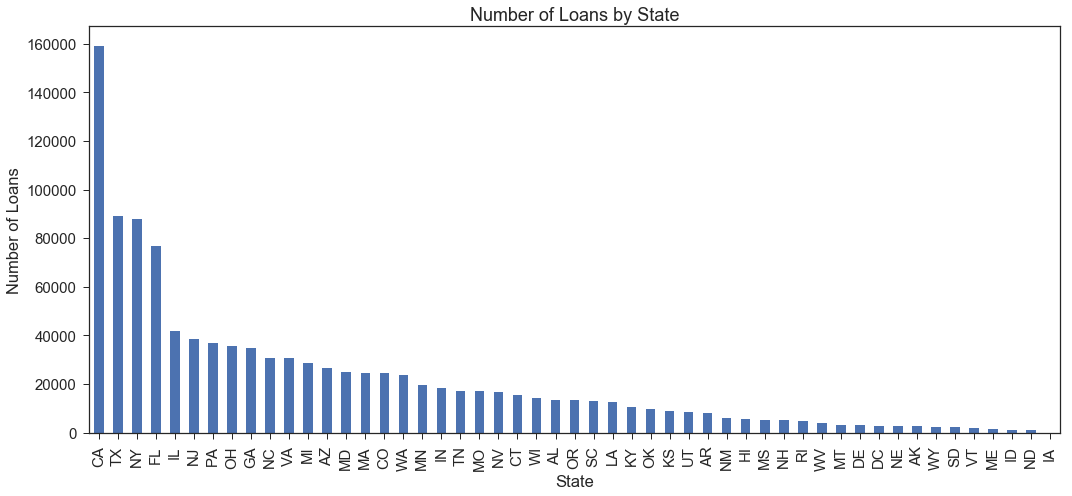

In [7]:
loan_origin=pd.DataFrame(loan_df.groupby('addr_state')['addr_state'].agg('count').sort_values(ascending=False))
loan_origin.plot(kind='bar', figsize=(15,7), legend=False)
plt.xlabel('State')
plt.ylabel('Number of Loans')
plt.title('Number of Loans by State')
plt.tight_layout()

In [8]:
adress_loan = ['addr_state', 'Loan Outcome']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(loan_df[adress_loan[0]], loan_df[adress_loan[1]]).style.background_gradient(cmap = cm)

Loan Outcome,Charged Off,Fully Paid
addr_state,,
AK,531,2115
AL,3306,10267
AR,1998,6106
AZ,5265,21386
CA,31475,127662
CO,3755,20591
CT,2731,12750
DC,374,2346
DE,622,2400


### Number of Fully Paid vs. Charged Off Loans by Date of Loan Issuance

We observe that there are fewer loans in our dataset from the more recent dates. This is not because the overall number of Lending Club loans has decreased recently, but rather because we only selected loans that have been completed (either fully paid or charged off, rather than those that are still in progress). 

In [9]:
dates = []
total_loans = []
fully_paid = []
charged_off = []

for year in range(2012,2019):
    for month in range(1,13):
        tmp = loan_df[loan_df['issue_d']==datetime(year,month,1)]
        dates.append(datetime(year,month,1))
        total_loans.append(tmp.shape[0])
        fully_paid.append(tmp[tmp['Loan Outcome']=='Fully Paid'].shape[0])
        charged_off.append(tmp[tmp['Loan Outcome']=='Charged Off'].shape[0])

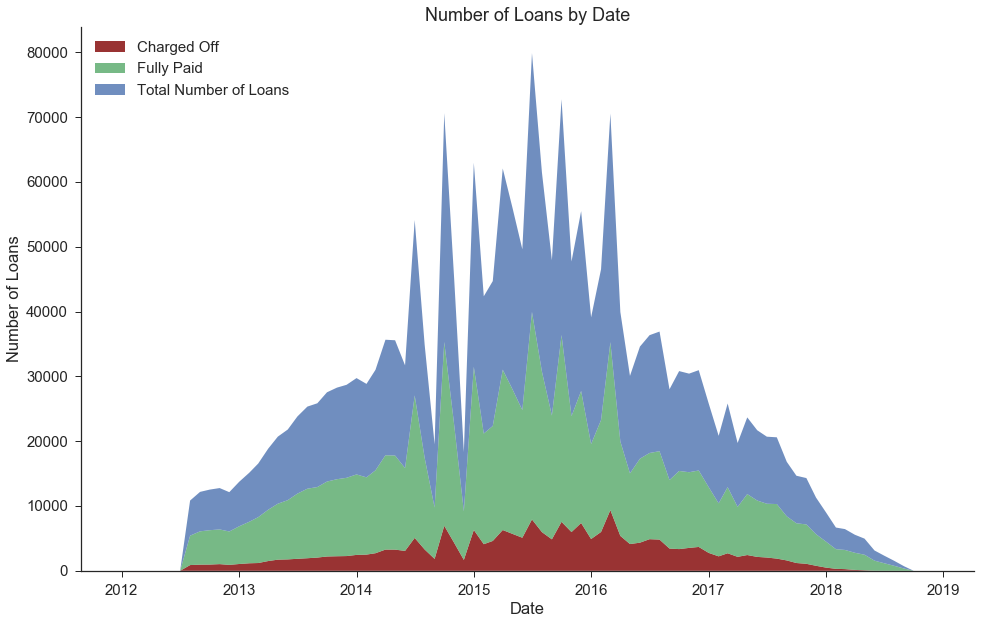

In [10]:
fig, ax = plt.subplots(figsize=(16,10))

plt.stackplot(dates,[charged_off,fully_paid,total_loans], 
              labels=['Charged Off','Fully Paid','Total Number of Loans'], 
              alpha=0.8,colors=['#800000', '#55a868', '#4c72b0'])


ax.set_title('Number of Loans by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loans')
plt.legend(loc='upper left')

sns.despine();

### Distribution of Annual Income

We observe that a large portion of the Lending Club loans have applicants who have incomes of around 50k to 70k per year. 

There appear to be loans issued to borrowers with very low income, including incomes of 0. This group may include students and people who have recently lost their jobs or had employment changes. It is also possible that these borrowers had co-signers.

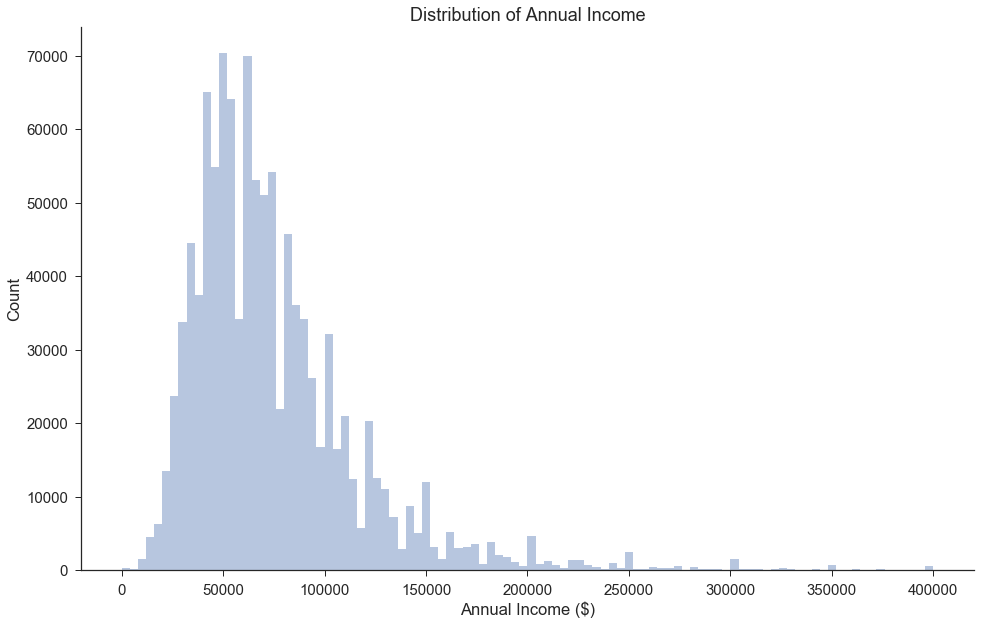

In [11]:
fig, ax = plt.subplots(figsize=(16,10))

sns.distplot(loan_df[loan_df['annual_inc']<=400000]['annual_inc'],bins=100,kde=False,rug=False)

ax.set_title('Distribution of Annual Income')
ax.set_xlabel('Annual Income ($)')
ax.set_ylabel('Count')

sns.despine();

### Borrower's Debt-to-Income Ratio vs. Lending Club Interest Rate (by Loan Grade)

Our main conclusion from the plot below is that there is a clear-cut relationship whereby riskier-grade loans have higher interest rates. Upon further investigation, we found that the "Lending Club’s interest rates take into account credit risk and market conditions"(Source: https://www.lendingclub.com/foliofn/rateDetail.action). The interest rate is assigned directly based on the loan subgrade and the current market conditions.

Riskier applicants also tend to have higher debt-to-income ratios, though the visualization below does not portray this as clearly.



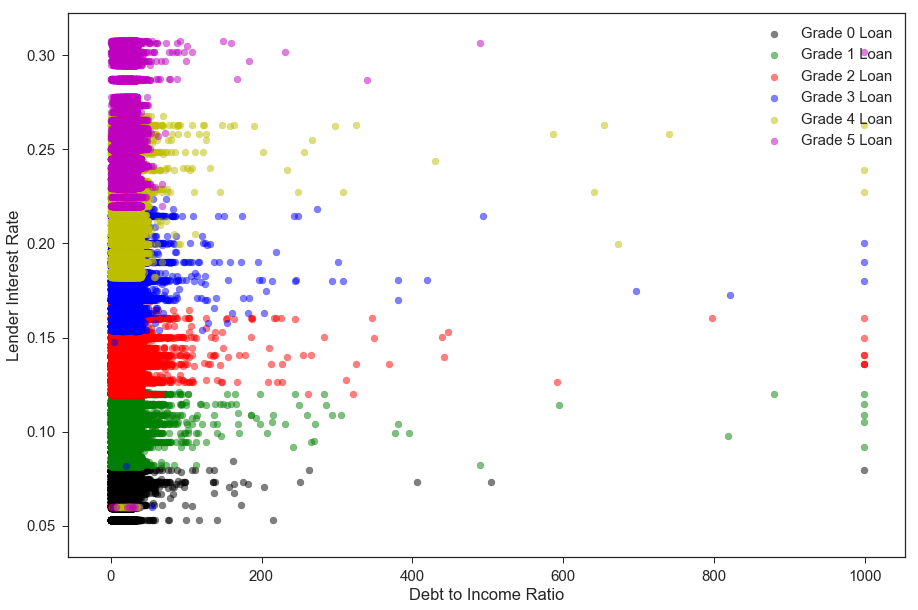

In [12]:
loan_df['interest_rate']=loan_df['int_rate']

#Interest Rates change over time. Let's look at 2018Q2 only.
tmp_df = loan_df[(loan_df['issue_d']>=datetime(2018,4,1))|(loan_df['issue_d']<datetime(2018,7,1))]
#tmp_df['grade'] = tmp_df['grade'].astype('category')

colors=['k','g','r','b','y','m','c']
counter=0
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for grade in np.sort(tmp_df['grade'].unique()[0:-1]):
    ax.scatter(tmp_df[tmp_df['grade']==grade].dti, tmp_df[tmp_df['grade']==grade].interest_rate, alpha=0.5, color=colors[counter], label='Grade '+ str(grade)+ ' Loan')
    counter+=1

ax.set_xlabel('Debt to Income Ratio')
ax.set_ylabel('Lender Interest Rate')
ax.legend(loc='best');

### Loan Purpose Distribution

The purpose of the large majority of the loans is categorized as debt consolidation, with credit card debt being the next-most common loan purpose. 

These categories likely include many individuals who have low incomes but expect to have higher incomes in the near future, including students or younger applicants who have recently joined the work force.

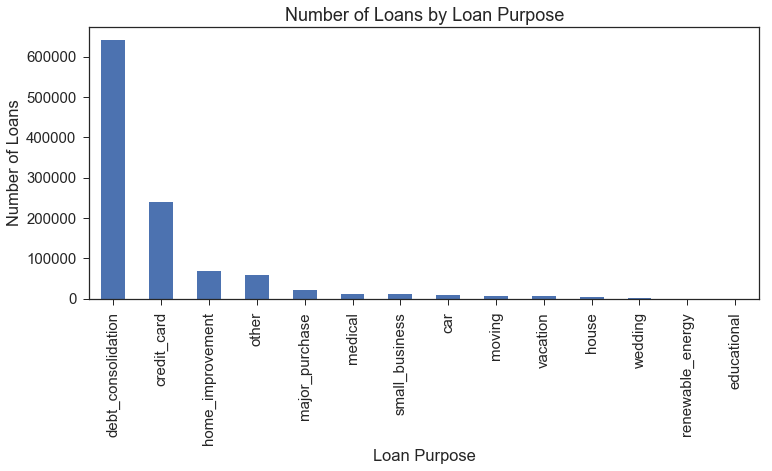

In [13]:
fund_purpose=pd.DataFrame(loan_df.groupby('purpose')['purpose'].agg('count').sort_values(ascending=False))
fund_purpose.plot(kind='bar', figsize=(12,5), legend=False)
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.title('Number of Loans by Loan Purpose');


### Removing Excess Columns

The following columns were already re-coded into dummy variables, and we only kept the original columns to facilitate EDA visualizations: `application_type`, `emp_length`, `home_ownership`, `purpose`, `term`, `verification_status`]

We also drop the columns we temporarily generated for visualization purposes: `Loan Outcome` and `interest_rate`


In [14]:
columns = ['application_type', 'emp_length', 'home_ownership', 'purpose', 'term',
           'verification_status', 'Loan Outcome', 'interest_rate']

loan_df = loan_df.drop(columns=columns)

loan_df.shape

(1087436, 87)

In [15]:
loan_df.to_pickle('./data/Pickle/clean_df.pkl')

## <font color='maroon'>Random Forest Feature Importances</font>

Since our full dataset is so large, we use a 10% sample of our dataset for the purposes of tuning and comparing baseline models.

We still have a large number of potential features, and we would like to get a sense of which features are most useful in predicting the loan outcome. We train a Random Forest Classifier and use the feature importances to select the top features. 

We specifically set max_depth=None to allow for all features to be incorporated.


In [7]:
clean_df = pd.read_pickle('./data/Pickle/clean_df.pkl').sample(frac=.10, random_state=0)
clean_df = clean_df.drop(columns= ['issue_d', 'zip_code', 'addr_state'])
outcome='fully_paid'

# split into train and validation sets
data_train, data_val = train_test_split(clean_df, test_size=.1, stratify=clean_df[outcome], random_state=99);

X_train = data_train.drop(columns=outcome)
y_train = data_train[outcome]

X_val = data_val.drop(columns=outcome)
y_val = data_val[outcome]

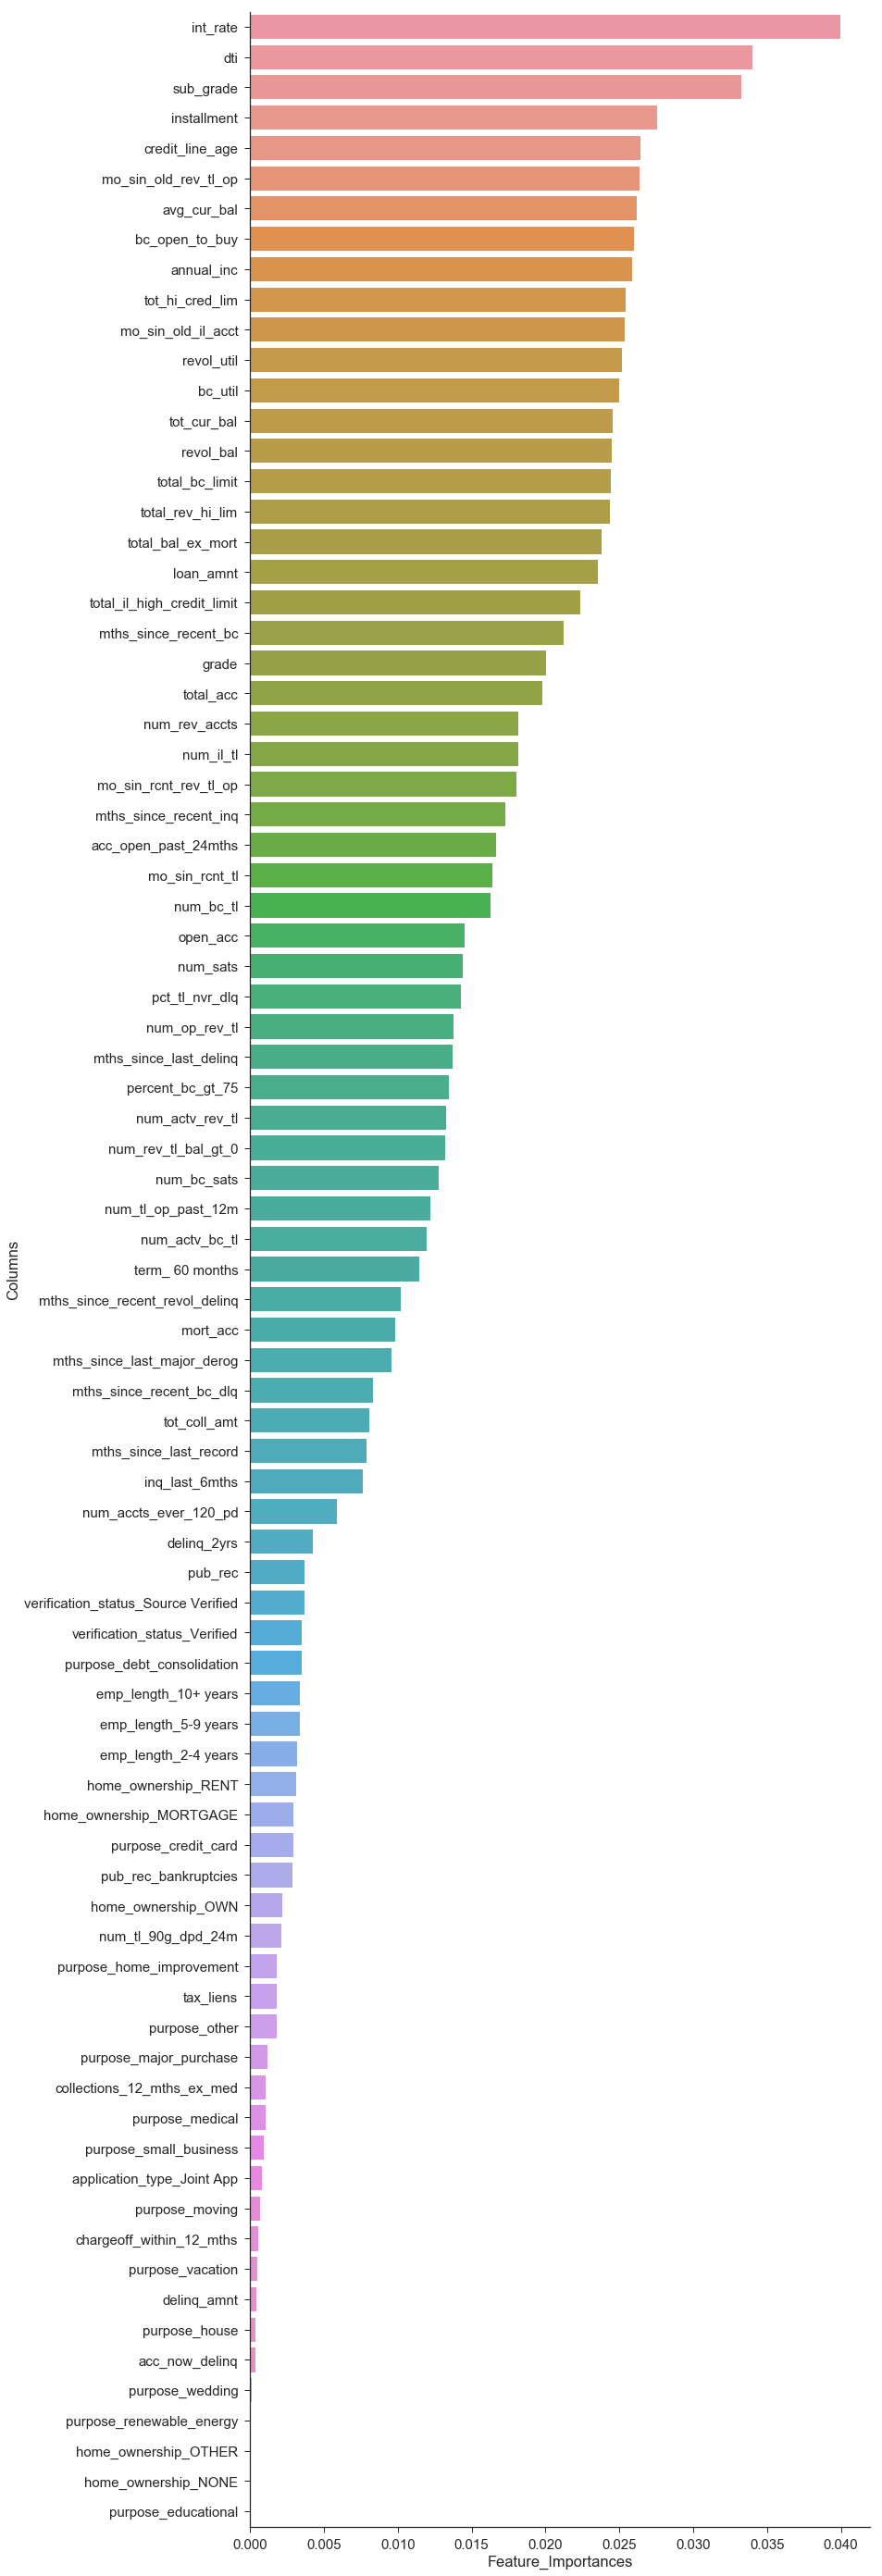

In [8]:
#Train random forest, allowing overfitting
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None).fit(X_train, y_train)

# view feature importances as dataframe
importances = pd.DataFrame({'Columns':X_train.columns,'Feature_Importances':rf_model.feature_importances_})
importances = importances.sort_values(by='Feature_Importances',ascending=False)
importances.head(20)

# plot feature importances
fig, ax = plt.subplots(figsize=(12,50))
ax = sns.barplot(x=importances['Feature_Importances'], y=importances['Columns'])
sns.despine()